# STAT 301 Final Group Report
## Group 1:
Arnav Gupta (70413034) 
Thomas Hesselbo (111)
Gracie Shao  
Frances Shen (46441242)


## I. Introduction

Tipping is a common social practice in many countries, especially in the United States, where it constitutes a significant portion of income for service workers. While there is no legal obligation to tip, social norms and individual perceptions often guide this behavior. Understanding the factors that influence tipping behavior can provide valuable insights for restaurant management, policymakers, and researchers studying consumer behavior and social psychology.

In this study, we investigate: **To what extent are customer and dining characteristics (e.g., bill amount, gender, smoking status, meal time, and party size) associated with tip amount in  a given restaurant?** Specifically, we aim to explore how variables such as the total bill amount, gender of the payer, smoking status, time of day, day of the week, and party size contribute to tipping behavior. A secondary objective is to determine which of these variables are statistically significant predictors of the tip amount, thereby shedding light on potential patterns or biases in tipping.

To address these questions, we utilize a dataset consisting of 245 individual dining transactions from a restaurant. Each entry records the total bill, the tip given, the gender and smoking status of the payer, the day and time of the meal, and the party size. The response variable in our analysis is tip, while the explanatory variables include total_bill, sex, smoker, day, time, and size.

Recent studies reveal that tipping behavior in restaurants is shaped by a mix of transactional and social factors. Total bill amount remains a strong predictor—larger bills often lead to higher tip amounts, though not always proportionally, as tip [percentages tend to decline with bigger tabs (Jahan, 2018). Party size also matters, with larger groups typically tipping less per person, likely due to shared responsibility (Lynn, 2021). Meanwhile, generational differences have emerged as a new area of interest, with Millennials and Gen Z shown to tip more generously on average than older generations (New York Post, 2025). Additionally, digital payment prompts are subtly reshaping tipping norms, introducing a sense of social pressure—sometimes referred to as “guilt tipping”—which may lead to increased tips regardless of service quality (News.com.au, 2024). These trends suggest that modern tipping behaviors are influenced not only by the meal itself but also by shifting cultural expectations and payment environments.

Grounded in existing research, our analysis explores how these well-documented patterns manifest in this dataset, aiming to understand the consistency of these factors in influencing tipping behavior—and to consider what any alignment or divergence from prior findings might suggest.

## II. Methods and Results

In [1]:
library(tidyverse)
library(glmnet)
library(tidymodels)
library(mltools)
library(leaps)
library(car)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1

## a) Data Description

Data source: https://www.kaggle.com/datasets/saurabhbadole/restaurant-tips-dataset/data

In [2]:
#Read data using reproducible code and from non-local file
tips_df <- read.csv("https://raw.githubusercontent.com/gracieS02/tips-2/refs/heads/main/tips.csv")
head(tips_df)

,total_bill,tip,sex,smoker,day,time,size
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4
6,25.29,4.71,Male,No,Sun,Dinner,4


The dataset contains 244 observations and 7 variables, collected from a restaurant over time. Each entry represents a unique transaction, detailing bill amount, tip, payer's gender, smoking preference, day, time, and party size, making the data observational since there is no control over variables. Here is a summary table of variables in the dataset:

In [3]:
#Viewing variable types and descriptions in a table
library(knitr)

data <- tibble(
  Variable = c("total_bill", "tip", "sex", "smoker", "day", "time", "size"),
  Type = c("Numeric (float)", "Numeric (float)", "Categorical (string, binary)", "Categorical (string, binary)", 
           "Categorical (string)", "Categorical (string, binary)", "Numeric (integer)"),
  Role = c("Predictor", "Response", "Predictor", "Predictor", "Predictor", "Predictor", "Predictor"),
  Description = c("Total bill amount (in USD)", "Tip amount (in USD)", "Sex of the customer (Male/Female)",
                  "Whether the customer is a smoker (Yes/No)", "Day of the week (Thur, Fri, Sat, Sun)",
                  "Meal type (Lunch/Dinner)", "Number of people in the dining party (1-6)")
)

kable(data, format = "markdown")



|Variable   |Type                         |Role      |Description                                |
|:----------|:----------------------------|:---------|:------------------------------------------|
|total_bill |Numeric (float)              |Predictor |Total bill amount (in USD)                 |
|tip        |Numeric (float)              |Response  |Tip amount (in USD)                        |
|sex        |Categorical (string, binary) |Predictor |Sex of the customer (Male/Female)          |
|smoker     |Categorical (string, binary) |Predictor |Whether the customer is a smoker (Yes/No)  |
|day        |Categorical (string)         |Predictor |Day of the week (Thur, Fri, Sat, Sun)      |
|time       |Categorical (string, binary) |Predictor |Meal type (Lunch/Dinner)                   |
|size       |Numeric (integer)            |Predictor |Number of people in the dining party (1-6) |

## b) Exploratory Data Analysis (EDA)

### 1) Data Cleaning and Wrangling

To begin the analysis, the `tips` dataset was loaded and cleaned using the `tidyverse` package.

- Categorical variables (`sex`, `smoker`, `day`, and `time`) were converted into factors for proper handling in plots and summaries.
- Column names were renamed for clarity (e.g., `total_bill` → `bill`, `sex` → `gender`, etc.).
- A missing data check was performed, which confirmed that there were no missing values present in the dataset.

This step ensures that the dataset is **tidy, consistent**, and ready for analysis.

In [4]:
# Convert categorical variables to factors
tips_df <- tips_df %>%
  mutate(
    sex = as.factor(sex),
    smoker = as.factor(smoker),
    day = as.factor(day),
    time = as.factor(time),
  )

# Rename columns for clarity
tips_df <- tips_df %>%
  rename(
    bill = total_bill,
    gender = sex,
    meal_time = time,
    party_size = size
  )

# Check for missing values
missing_summary <- colSums(is.na(tips_df))
print(missing_summary)

      bill        tip     gender     smoker        day  meal_time party_size 
         0          0          0          0          0          0          0 


With all variables correctly formatted and the dataset clean, we proceeded to the next step in exploratory data analysis.

### 2) Distribution of Variables

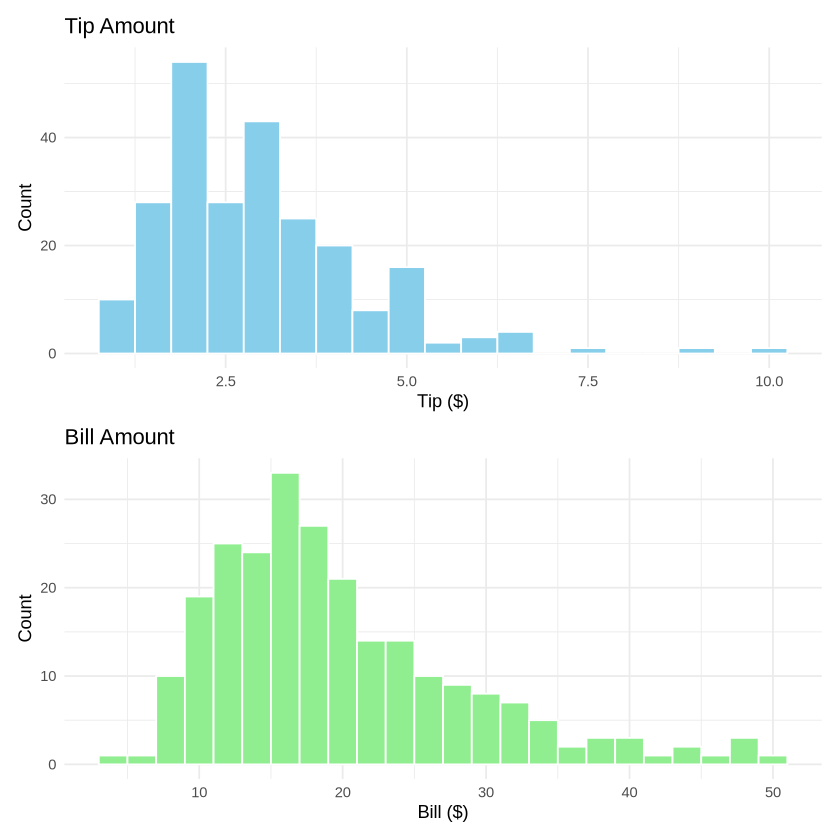

In [5]:
# Histogram for tip
p1 <- ggplot(tips_df, aes(x = tip)) +
  geom_histogram(binwidth = 0.5, fill = "skyblue", color = "white") +
  labs(title = "Tip Amount", x = "Tip ($)", y = "Count") +
  theme_minimal()

# Histogram for bill
p2 <- ggplot(tips_df, aes(x = bill)) +
  geom_histogram(binwidth = 2, fill = "lightgreen", color = "white") +
  labs(title = "Bill Amount", x = "Bill ($)", y = "Count") +
  theme_minimal()

p1 + p2 + plot_layout(ncol = 1)

The two continuous variables in the dataset, `bill` and `tip`, both exhibit **right-skewed distributions**, as shown in the histograms above. Most customers leave relatively small tips (between $\$$2–4), and the majority of bills fall within the $\$$10–25 range, with a long tail extending toward higher amounts.

This skewness raises two modeling considerations. First, linear regression assumes that residuals are normally distributed, which may not hold if the response variable (`tip`) is highly skewed. Second, if a small number of high-bill observations exert disproportionate influence on the model, it could inflate variance and bias the slope estimates. These effects should be monitored using residual diagnostics after model fitting. If necessary, transformations such as `log(tip)` or `log(bill)` may help stabilize variance and improve model fit.

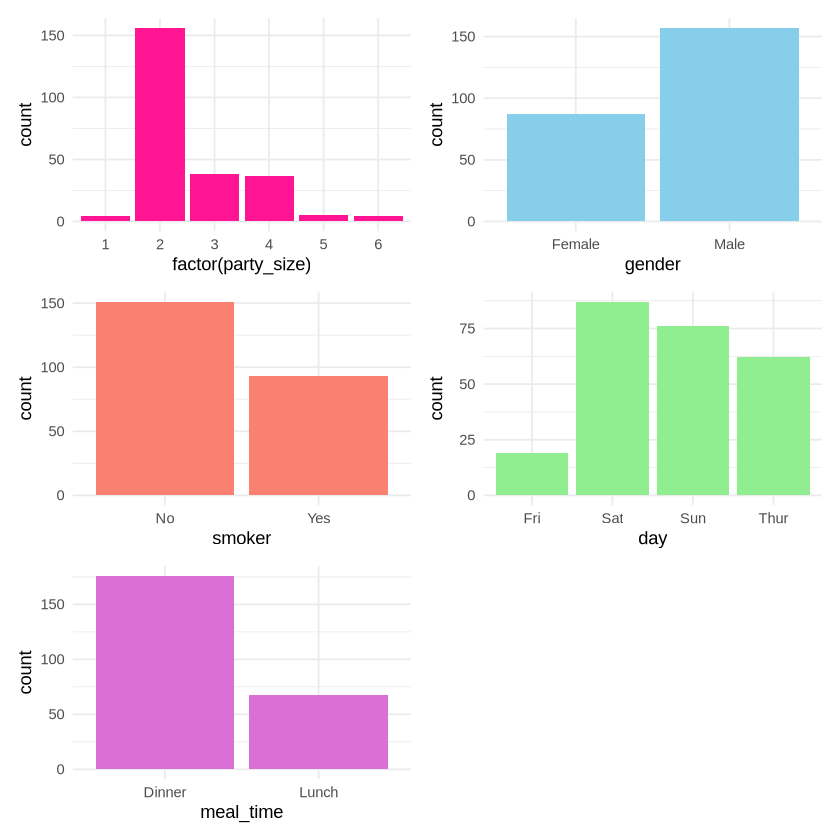

In [6]:
p3 <- ggplot(tips_df, aes(x = factor(party_size))) + geom_bar(fill = "deeppink") + theme_minimal()
p4 <- ggplot(tips_df, aes(x = gender)) + geom_bar(fill = "skyblue") + theme_minimal()
p5 <- ggplot(tips_df, aes(x = smoker)) + geom_bar(fill = "salmon") + theme_minimal()
p6 <-ggplot(tips_df, aes(x = day)) + geom_bar(fill = "lightgreen") + theme_minimal()
p7 <-ggplot(tips_df, aes(x = meal_time)) + geom_bar(fill = "orchid") + theme_minimal()


p3 + p4 + p5 + p6 + p7 + plot_layout(ncol = 2)

Among the categorical variables, several show **imbalanced level distributions**. For instance, the majority of dining parties are size 2, and dinner meals greatly outnumber lunch meals. Male customers and non-smokers are also overrepresented compared to their counterparts.

These imbalances pose potential concerns during modeling. **Underrepresented levels (e.g., party sizes 1, 5, and 6, or Friday diners) can result in unstable coefficient estimates** with large standard errors, making interpretation difficult. Additionally, structural patterns between categorical variables — such as a higher proportion of Saturday dinners compared to Saturday lunches — could introduce confounding. For example, if smokers predominantly appear during lunch and tipping is lower at lunch overall, we might mistakenly attribute lower tipping behavior to smoking rather than meal time.

To address this, it is important to explore cross-tabulations and interaction effects (e.g., `smoker` × `meal_time`) and be cautious when interpreting effects for categories with limited representation.

### 3) Variable Interactions

In [7]:
# Observations per Category
tips_df %>%
  count(gender, smoker, day, meal_time) %>%
  arrange(day, meal_time)

gender,smoker,day,meal_time,n
<fct>,<fct>,<fct>,<fct>,<int>
Female,No,Fri,Dinner,1
Female,Yes,Fri,Dinner,4
Male,No,Fri,Dinner,2
Male,Yes,Fri,Dinner,5
Female,No,Fri,Lunch,1
Female,Yes,Fri,Lunch,3
Male,Yes,Fri,Lunch,3
Female,No,Sat,Dinner,13
Female,Yes,Sat,Dinner,15


This table provides a count of observations for each combination of `gender`, `smoker` status, `day`, and `meal_time`.

From the data, we observe that:

- **Most observations occur on the weekend**, especially Saturday and Sunday during dinner time.
- The largest subgroup is **Male, Non-Smoker, Sunday Dinner** with **43 entries**.
- Some combinations, like **Female, Non-Smoker, Friday Lunch**, only have **1 observation**, indicating **sparse or underrepresented groups**.

This information is important for analysis, as small sample sizes in certain subgroups may reduce reliability or cause misleading patterns in visualizations. It also justifies the use of faceting in plots to reveal richer group-wise structure.

We explored all 32 possible combinations of gender, smoker status, day, and meal time. The resulting contingency table revealed several combinations with very low sample sizes (fewer than 5 observations) and some with no data at all. This poses challenges for inference, particularly when estimating effects for underrepresented groups.  

In particular, due to the absence of lunch observations on weekends and the limited dinner observations on Thursday, there is a strong association between day and meal_time in the dataset. This dependence creates a potential collinearity issue, where the effects of day and meal_time become difficult to separate. As a result, we avoid including interaction terms between these two variables, and consider collapsing days into broader categories (e.g., weekday vs. weekend) to reduce structural redundancy.

### 4) Exploring Relationships Between Predictors and Tip

#### Plot 1: Tip vs. Total Bill (Multi-variable Scatterplot)

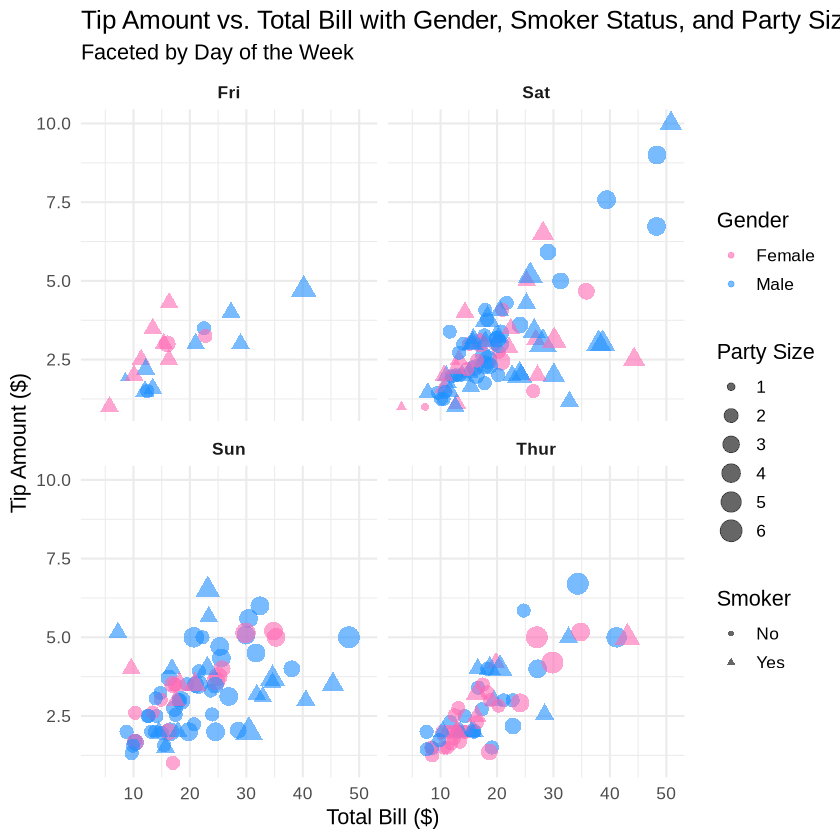

In [8]:
ggplot(tips_df, aes(x = bill, y = tip, color = gender, shape = smoker, size = party_size)) +
  geom_point(alpha = 0.6, stroke = 0.3) +
  facet_wrap(~ day) +
  scale_size_continuous(range = c(2, 6)) +
  scale_color_manual(values = c("Female" = "#FF69B4", "Male" = "#1E90FF")) +
  labs(
    title = "Tip Amount vs. Total Bill with Gender, Smoker Status, and Party Size",
    subtitle = "Faceted by Day of the Week",
    x = "Total Bill ($)",
    y = "Tip Amount ($)",
    color = "Gender",
    shape = "Smoker",
    size = "Party Size"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    legend.position = "right",
    strip.text = element_text(face = "bold")
      )

This scatterplot visualizes the relationship between **total bill** and **tip amount**, incorporating four variables:

- **Color** represents `gender` (pink = Female, blue = Male)
- **Shape** represents `smoker` status (circle = No, triangle = Yes)
- **Size** reflects `party_size` as a numeric variable
- The plot is **faceted by `day` of the week**, allowing for comparison across days

Key observations:
- There is a **positive correlation** between total bill and tip across all days — higher bills generally lead to higher tips.
- Most tips fall in the \$2–5 range, with some **notable outliers** over \$7, especially on **Saturday and Sunday**.
- Larger party sizes (bigger dots) tend to be associated with larger total bills, though not always with higher tips.
- No obvious visual difference appears between **smokers and non-smokers** or **males and females**

This plot is useful because it packs multiple variables into a single view and highlights both general trends and group-based variation. It also reveals that some **party sizes are much less frequent**, which aligns with findings from the summary tables.



#### Plot 2: Average Tip Amount by Day and Gender (Heatmap)

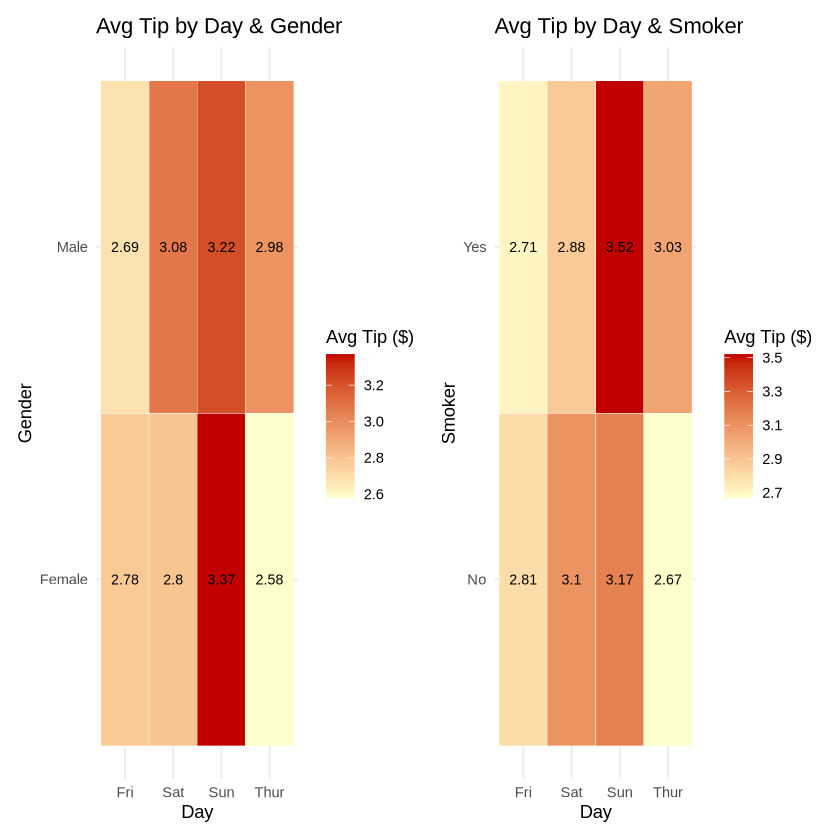

In [9]:
# Plot 1: Tip by Day and Gender
plot_gender <- tips_df %>%
  group_by(day, gender) %>%
  summarise(avg_tip = round(mean(tip), 2), .groups = "drop") %>%
  ggplot(aes(x = day, y = gender, fill = avg_tip)) +
  geom_tile(color = "white") +
  geom_text(aes(label = avg_tip), color = "black", size = 3) +
  scale_fill_gradient(low = "#ffffcc", high = "#c10000") +
  labs(
    title = "Avg Tip by Day & Gender",
    x = "Day",
    y = "Gender",
    fill = "Avg Tip ($)"
  ) +
  theme_minimal(base_size = 11)

# Plot 2: Tip by Day and Smoker
plot_smoker <- tips_df %>%
  group_by(day, smoker) %>%
  summarise(avg_tip = round(mean(tip), 2), .groups = "drop") %>%
  ggplot(aes(x = day, y = smoker, fill = avg_tip)) +
  geom_tile(color = "white") +
  geom_text(aes(label = avg_tip), color = "black", size = 3) +
  scale_fill_gradient(low = "#ffffcc", high = "#c10000") +
  labs(
    title = "Avg Tip by Day & Smoker",
    x = "Day",
    y = "Smoker",
    fill = "Avg Tip ($)"
  ) +
  theme_minimal(base_size = 11)

plot_gender + plot_smoker + plot_layout(ncol = 2)

This heatmap visualizes the **average tip amount** by **gender** and **day of the week**, allowing for comparison of group-level tipping patterns based on gender which wasn't explicitly visible with the scatterplot.

Key takeaways:
- **Sunday** has the highest average tip amounts for both genders:  
  - Female: **\$3.37**  
  - Male: **\$3.22**
- **Thursday** shows the lowest average tips:  
  - Female: **\$2.58**  
  - Male: **\$2.98**
- The gender differences are small overall, but **females tip slightly more** than males on Friday and Sunday, while **males tip more** on Thursday and Saturday.

The accompanying heatmap by **smoker status** reveals similar patterns:
- **Smokers** tip the most on **Sunday** (**\$3.52**), but this is not consistent across other days.
- **Non-smokers** tip slightly more on Friday and Saturday, while smokers lead on Sunday and Thursday.
- Overall, the differences between smokers and non-smokers are small and **inconsistent**, suggesting that **smoker status does not have a meaningful impact** on average tipping behavior.

Together, these heatmaps highlight **day of the week** as the most influential factor, while **gender and smoking status appear to play minimal roles** in shaping average tip amounts.

#### Conclusion

This exploratory analysis revealed clear relationships between total bill and tip amount, with larger bills generally resulting in higher tips. Group-level patterns showed that tips tend to be highest on weekends, especially Sundays, and that gender and smoker status may play minor roles in tipping behavior. 

By combining individual-level visualizations (scatterplot) with group-level summaries (heatmap), we captured both granular variability and broader trends. These insights can help inform further modeling or guide targeted analyses.

(Mention that we removed 'meal_time' and how will that help with fitting the linear model)

### B. Table: Summary Statistics by Group

In [10]:
tips_df %>%
  group_by(day, smoker) %>%
  summarise(
    n = n(),
    avg_bill = round(mean(bill), 2),
    avg_tip = round(mean(tip), 2),
    .groups = "drop"
  )

day,smoker,n,avg_bill,avg_tip
<fct>,<fct>,<int>,<dbl>,<dbl>
Fri,No,4,18.42,2.81
Fri,Yes,15,16.81,2.71
Sat,No,45,19.66,3.10
Sat,Yes,42,21.28,2.88
Sun,No,57,20.51,3.17
Sun,Yes,19,24.12,3.52
Thur,No,45,17.11,2.67
Thur,Yes,17,19.19,3.03


This table shows the average **total bill** and **tip amount** for each combination of `day` and `smoker` status.

Key observations:
- **Sunday** has the highest average total bills overall, particularly among **smokers (\$24.12)**.
- The highest **average tip** also occurs on **Sunday for smokers (\$3.52)**.
- **Smokers tend to leave slightly higher average tips** than non-smokers on **Sunday and Thursday**, but this pattern is not consistent across all days.
- On **Friday**, non-smokers have slightly higher average tips than smokers despite having fewer observations.
- The **difference in averages is relatively small**, suggesting that **smoker status may have a subtle or inconsistent effect** on tipping, but this could be explored further using modeling techniques.

This summary helps highlight **group-level patterns** that inform which variables may be influential in predicting tip behavior.


### C. Summary by Party Size

In [11]:
tips_df %>%
  group_by(party_size) %>%
  summarise(
    count = n(),
    avg_bill = round(mean(bill), 2),
    avg_tip = round(mean(tip), 2),
    .groups = "drop"
  )

party_size,count,avg_bill,avg_tip
<int>,<int>,<dbl>,<dbl>
1,4,7.24,1.44
2,156,16.45,2.58
3,38,23.28,3.39
4,37,28.61,4.14
5,5,30.07,4.03
6,4,34.83,5.22


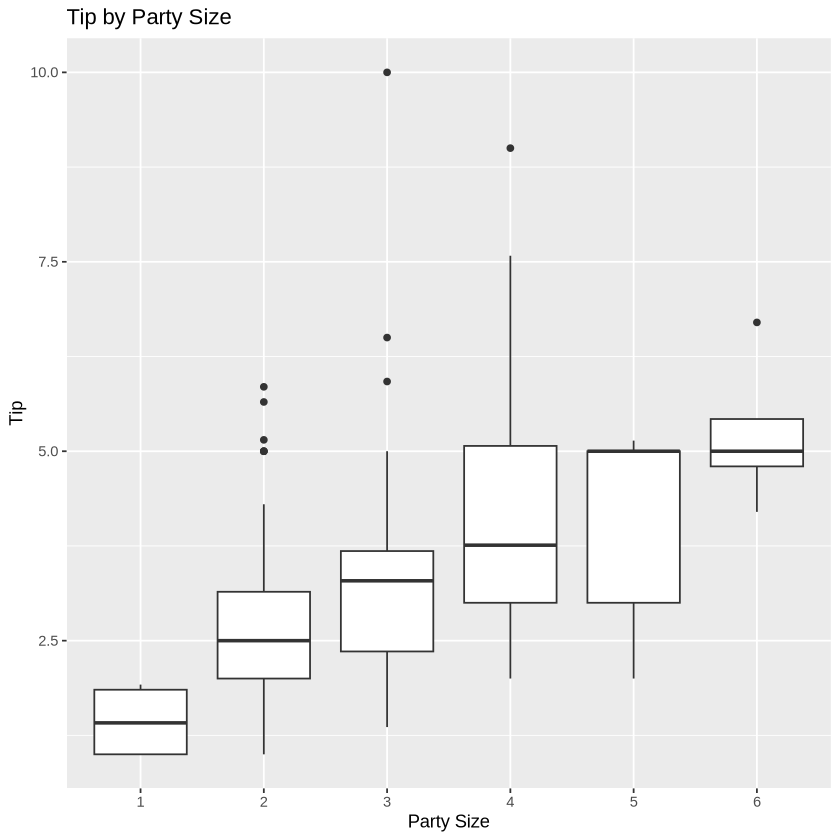

In [12]:
ggplot(tips_df, aes(x = factor(party_size), y = tip)) +
  geom_boxplot() +
  labs(title = "Tip by Party Size", x = "Party Size", y = "Tip")

This table summarizes how **party size** relates to the **average total bill** and **average tip amount**.

Key takeaways:
- As **party size increases**, both **average bill** and **average tip** generally increase.
- For example:
  - A party size of 2 has an average tip of **\$2.58**, while
  - A party of 6 tips an average of **\$5.22** — more than double.
- There is a **clear upward trend**, but...
- The **sample sizes are highly unbalanced**: 156 out of 244 entries are for parties of size 2, while party sizes of 5 or 6 have very few observations (5 and 4, respectively).

This trend raises caution: insights about large party sizes may be **less reliable due to limited data**.


### 1) Check for Linearity and Equal Variance (Homoscedasticity)

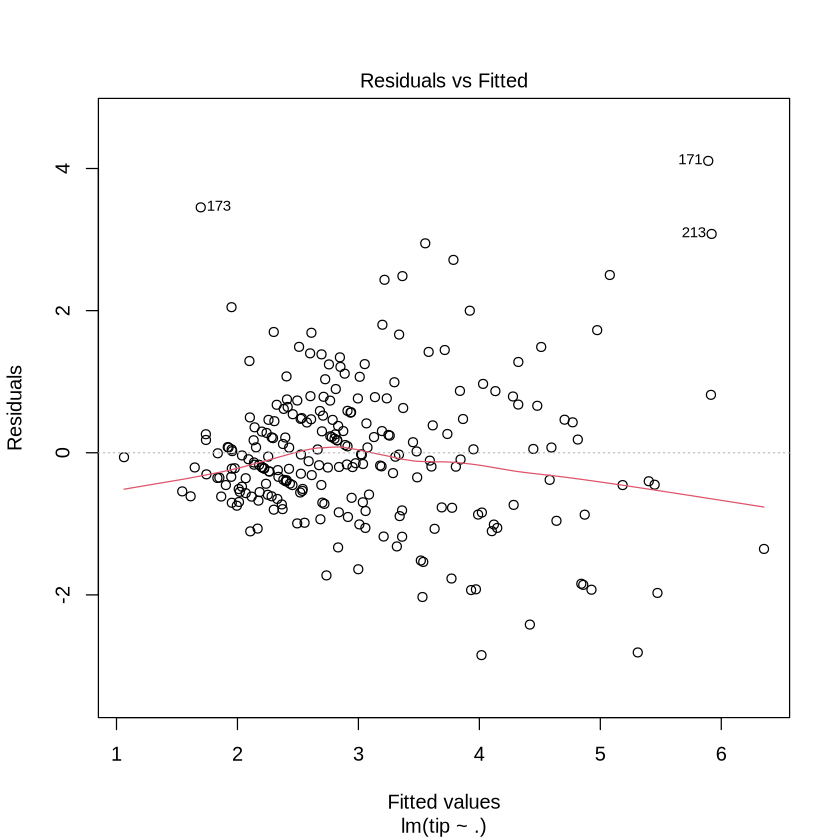

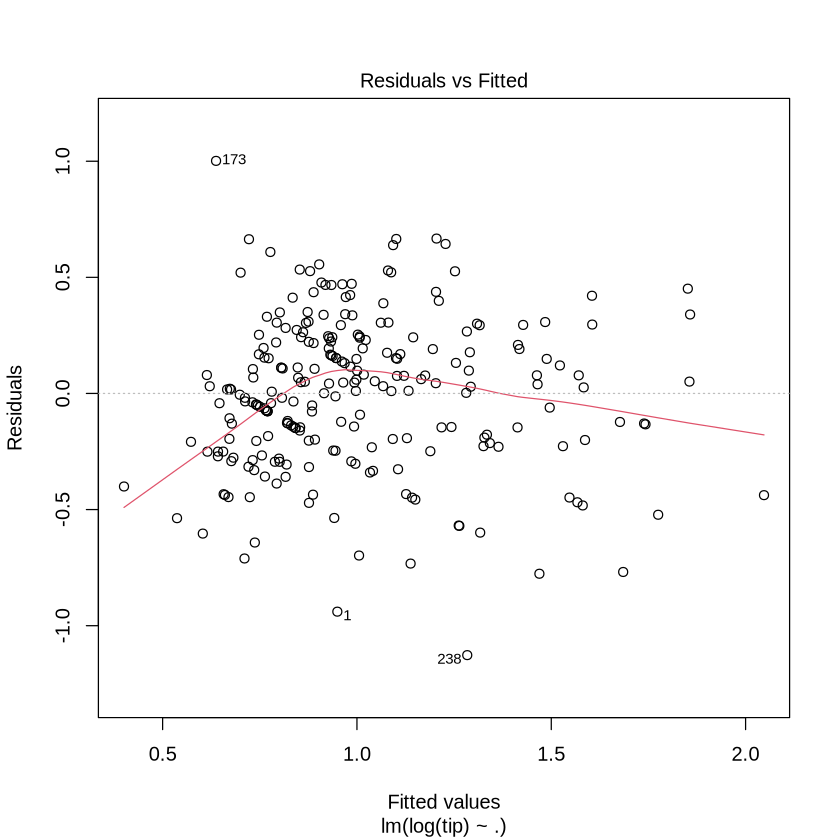

In [13]:
model <- lm(tip ~ ., data = tips_df)
plot(model, which = 1)  # Residuals vs Fitted

log_model <- lm(log(tip) ~ ., data = tips_df)
plot(log_model, which = 1)  # Residuals vs Fitted after Response Variable Transformation

Interpretation of the plots:
- For the **top plot**, the residuals show a slight fanning out (heteroscedasticity), especially as the fitted values increase. This shows that the assumption of linear regression is violated to some degree. 
- For the **bottom plot**, the residuals appear more evenly spread around the horizontal line with less fanning. Transforming the response variable using log(tip) seems to improved the model fit. 

In this case, we’re only noting the **slight** violation of homoscedasticity and won’t transform the response, as it would complicate inference and interpretation.

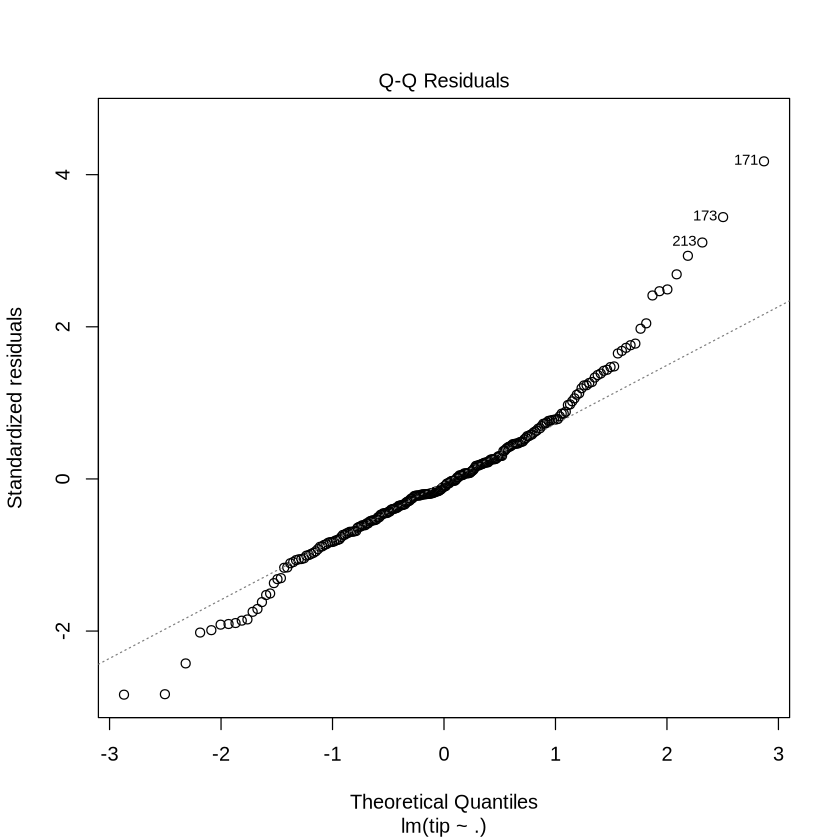

In [14]:
plot(model, which = 2)  # Q-Q plot

Interpretation of Q-Q plot:
- Most points fall along the diagnal line, showing that residuals are approximately normally distributed.
- However, both tails seems to slightly deviate from the line.
- A few outliers (like points 171, 173, 213) are labeled, showing there are some extreme residuals.

So, this is not a major concern, as our sample size isn't too small and we don't rely heavyly on the normality assumption, this deviation is acceptable. 

`geom_smooth()` using formula = 'y ~ x'


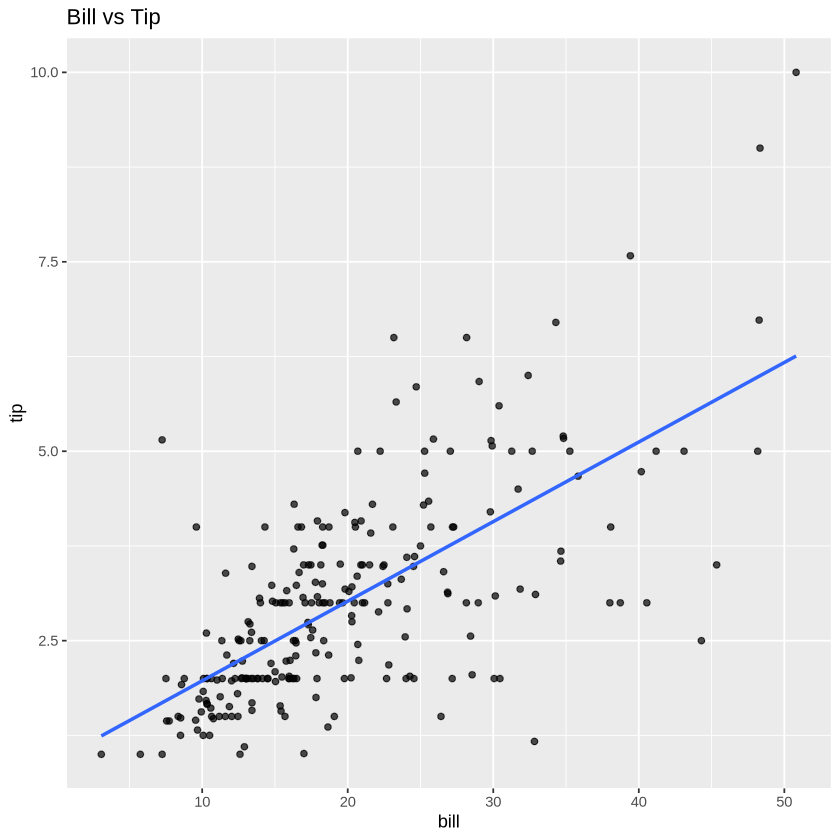

In [15]:
  ggplot(tips_df, aes(x = bill, y = tip)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Bill vs Tip")

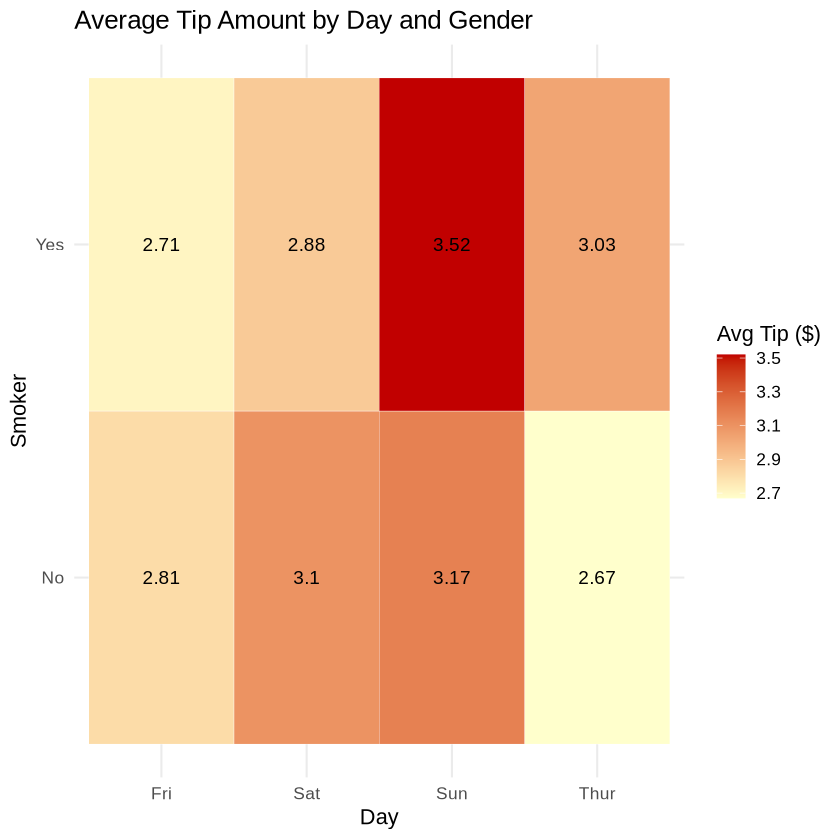

In [16]:
tips_df %>%
  group_by(day, smoker) %>%
  summarise(avg_tip = round(mean(tip), 2), .groups = "drop") %>%
  ggplot(aes(x = day, y = smoker, fill = avg_tip)) +
  geom_tile(color = "white") +
  geom_text(aes(label = avg_tip), color = "black", size = 4) +
  scale_fill_gradient(low = "#ffffcc", high = "#c10000") +
  labs(
    title = "Average Tip Amount by Day and Gender",
    x = "Day",
    y = "Smoker",
    fill = "Avg Tip ($)"
  ) +
  theme_minimal(base_size = 13)

## C) Methods: Plan

First, we are splitting the data into 70% of a training set, and 30% a testing set. The training set will be used to select variables, and the testing set will be used to verify the selection to attest for the accuracy of the model created using the training set, compare it with other models such as the null and the full. Finnaly, it will be used to establish the association between selected variables and the response, along with which of these variables are statistically significant. In the end, this will provide us with an infered assocation between the tips and the selected variables which are significant.

In [17]:
#Setting seed so that the randomness is reproducable
set.seed(1234)

#Setting up the split
tips_split <- tips_df |>
    initial_split(prop = 0.7, strata = tip)

#Assinging split to variables
tips_train <- training(tips_split)
tips_test <- testing(tips_split)

In [18]:
#tips_step <- stepAIC(lm(tip ~ .,tips))

Here, we are running a forward stepwise algorithm. This is being used to select which show a reasonable correlation in the training set.

In [19]:
#running forward selection algorithm
tips_forward_selection <- regsubsets(x = tip ~ bill + gender + smoker + day + party_size, nvmax = 8,
                                  data = tips_train,
                                  method = "forward")

#Viewing output of the forward selection algorithm in terms of the order in which variables are best correlated with the response
tips_forward_summary <- summary(tips_forward_selection)
tips_forward_summary

Subset selection object
Call: regsubsets.formula(x = tip ~ bill + gender + smoker + day + party_size, 
    nvmax = 8, data = tips_train, method = "forward")
7 Variables  (and intercept)
           Forced in Forced out
bill           FALSE      FALSE
genderMale     FALSE      FALSE
smokerYes      FALSE      FALSE
daySat         FALSE      FALSE
daySun         FALSE      FALSE
dayThur        FALSE      FALSE
party_size     FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: forward
         bill genderMale smokerYes daySat daySun dayThur party_size
1  ( 1 ) "*"  " "        " "       " "    " "    " "     " "       
2  ( 1 ) "*"  " "        " "       " "    " "    " "     "*"       
3  ( 1 ) "*"  " "        "*"       " "    " "    " "     "*"       
4  ( 1 ) "*"  "*"        "*"       " "    " "    " "     "*"       
5  ( 1 ) "*"  "*"        "*"       " "    "*"    " "     "*"       
6  ( 1 ) "*"  "*"        "*"       "*"    "*"    " "     "*"       
7  ( 1 ) "*"  "*"     

Here we are looking at the RSQ, RSS, and adjusted R^2 values for different number of input variables. This allows us to select a number of input variables, by looking at when the Aadjusted R2 starts to drop when adding additional input variables.

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.5088118,170.3694,0.5058528
2,0.5164914,167.7057,0.5106307
3,0.5186569,166.9547,0.5098518
4,0.5196344,166.6156,0.5078463
5,0.5196752,166.6014,0.5048504
6,0.5197377,166.5798,0.5018397
7,0.5197693,166.5688,0.4987592


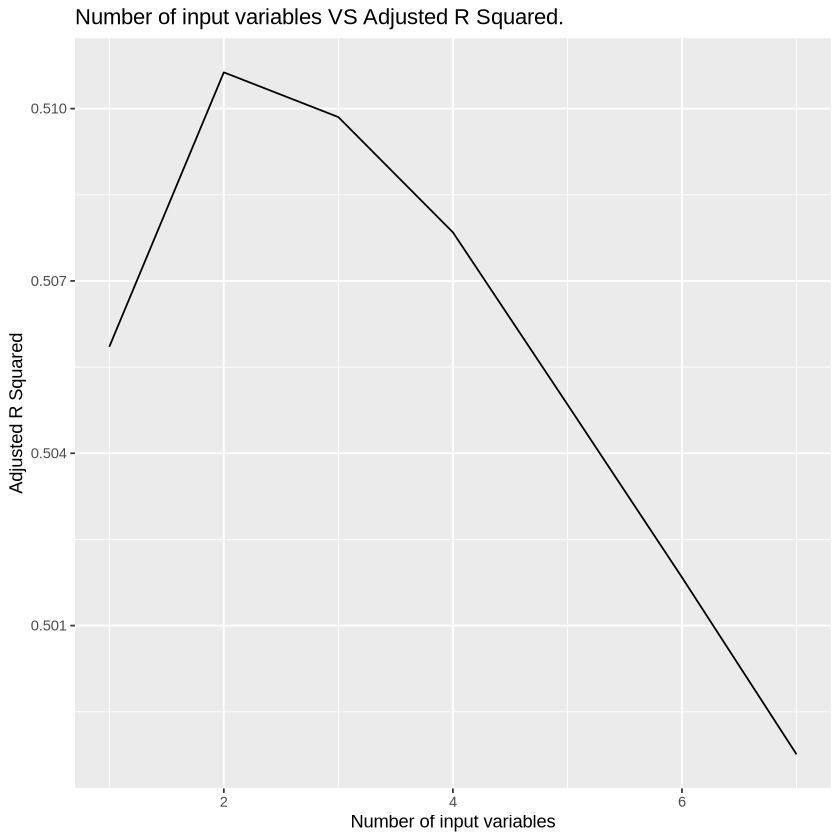

In [20]:
tips_fwd_summary_df <- 
    tibble(
        n_input_variables = 1:7,
        RSQ = tips_forward_summary$rsq,
        RSS = tips_forward_summary$rss,
        ADJ.R2 = tips_forward_summary$adjr2
    )
tips_fwd_summary_df
ggplot(tips_fwd_summary_df,aes(x =  n_input_variables,y = ADJ.R2)) +
geom_line() + 
labs(x = "Number of input variables",
     y = "Adjusted R Squared",
     title = "Number of input variables VS Adjusted R Squared.")


As we can see, the adjusted R^2 starts to drop after 2 input variables, so this indicates we should create a model with 2 input variables. Based on the forward selection results from earlier, these 2 variables should be the ones with the strongest correlation with tip, being the total bill and size.

Here we are checking the VIF of all the variables, to see if any may inflate our P. values later on and thus should be removed

In [21]:
vif(lm(tip ~ . - meal_time, tips_train))

,GVIF,Df,GVIF^(1/(2*Df))
bill,1.663627,1,1.289817
gender,1.122961,1,1.059699
smoker,1.156425,1,1.075372
day,1.238956,3,1.036357
party_size,1.650646,1,1.284775


Our selected variables (Bill and party_size) do not have large enough GVIFs (>5), and thus we do not need to take further action here.

Here we are generating the linear model utilizing the test set, which we will use to determine the association between tips and the selected variables

In [22]:
tips_linear_model <- lm(tip ~ bill + party_size, tips_test)

Here we are testing the linear model against the null model utilizing an F test, to see if it preforms better than the null model for the test set. 

In [23]:
anova(lm(tip ~ 1, tips_test),tips_linear_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,75,117.67307,NA,NA,NA,NA
2,73,76.67159,2,41.00148,19.51902,1.619737e-07


We will also test it against the full model.

In [24]:
anova(tips_linear_model, lm(tip ~ ., tips_test))

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,73,76.67159,NA,NA,NA,NA
2,67,72.02565,6,4.645938,0.7202939,0.6346344


We can see that our model outpreforms both the null model and the full model at the 0.05 significance level. This is a good indicator that our model provides a reasonable association bettween tip amount and the selected variables.

Here, we use tidy to see the association bettween the predictor variables and the response, as well as the p value for each. These will be evaluated at the 0.05 significance level

In [25]:
tidy(tips_linear_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.92514056,0.3498233,2.644594,0.0100074031
bill,0.06557151,0.0186871,3.508918,0.0007745505
party_size,0.28154416,0.1502867,1.873381,0.0650189193


Based on the results, a statistically significant we can see that an increase in bill by 1$ is associated with a 0.06557 dollar increase in tip amount, holding party_size constant. Additionally, while this result is not significant at the 0.05 level, an, increase in party_size by 1 person in associated with a increase in tip amount by 0.2815 dollars.

## III. Discussion

In [26]:
# Write

## IV. References

Badole, S. (n.d.). Restaurant Tips Dataset. Kaggle. Retrieved from 
https://www.kaggle.com/datasets/saurabhbadole/restaurant-tips-dataset

Jahan, N. (2018). Tipping behavior in the United States: An analysis of the impact of total bill 
and service quality on tip amount (Master’s thesis, South Dakota State University). Open 
PRAIRIE. https://openprairie.sdstate.edu/etd/2533

Lynn, M. (2021). Restaurant tipping research: A review of recent findings and future directions. 
Cornell Hospitality Quarterly, 62(1), 52–63. https://doi.org/10.1177/1938965520971495

News.com.au. (2024, March 4). Aussie wait staff divided on new dining trend. 
https://www.news.com.au/finance/business/retail/aussie-wait-staff-divided-on-new-dining-trend/news-story/ed7c99087c9845f4c2fdea9ff1dcbb73

New York Post. (2025, March 20). Which generation tips the most — and how states rank: 
Survey. https://nypost.com/2025/03/20/lifestyle/which-generation-tips-the-most-and-how-states-rank-survey/
